# 深入理解 JVM

因为分析框架里面出现过一些词语，所以我觉得有必要看本书学习学习名词。

主要是对类文件 .class file 和 JVM 的类加载器 classloader 的粗浅学习。

## Chapter 6 类文件结构

感觉一开头写了堆废话。不过给了我一个启示——如果字节码指令本身功能有限的话，是不可能支持 Java 这样的高级语言的。所有依托 JVM 运行的语言，其实现的特性肯定要建立在 JVM 指令上才是。

## 1. class file format

### i. 总 format

我感觉我甚至可以写个简单的解析器了，因为这个 format 太简单：

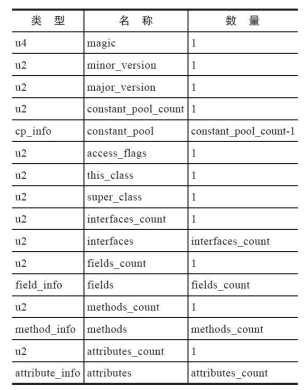

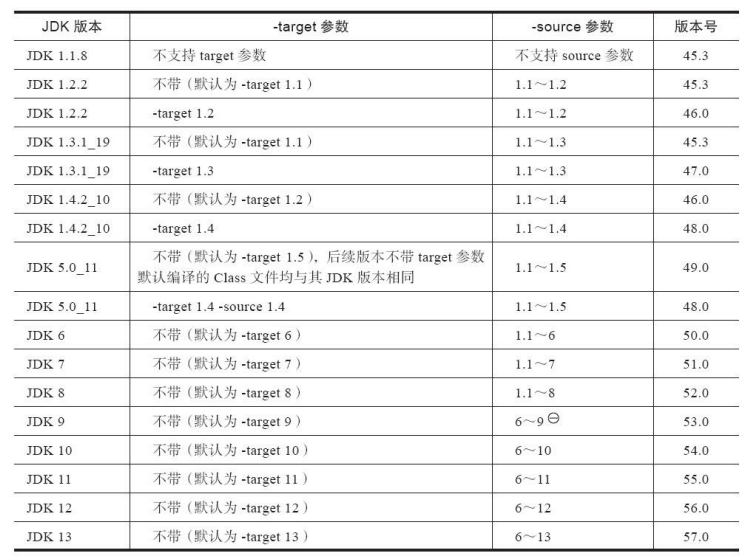

### ii. 常量池类型和结构

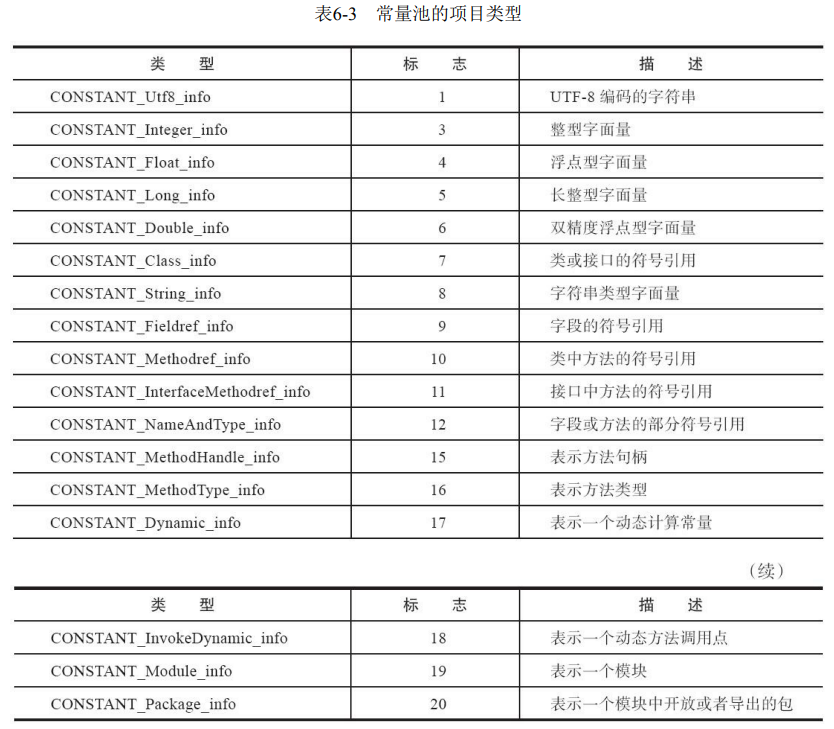

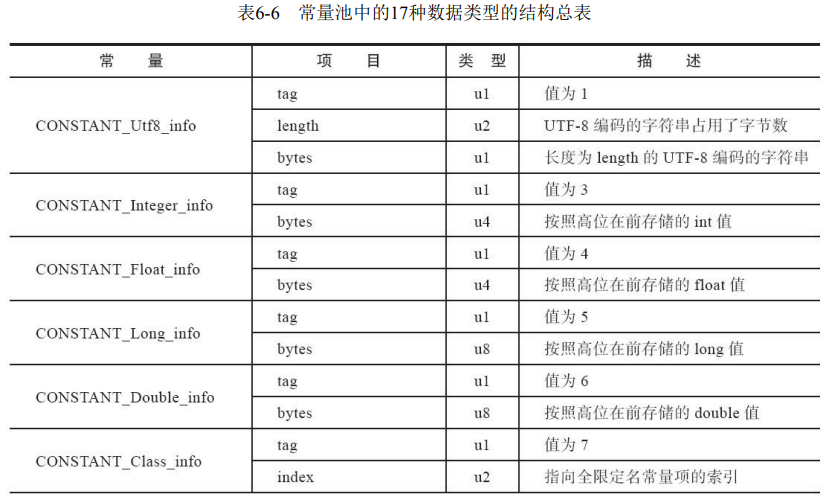

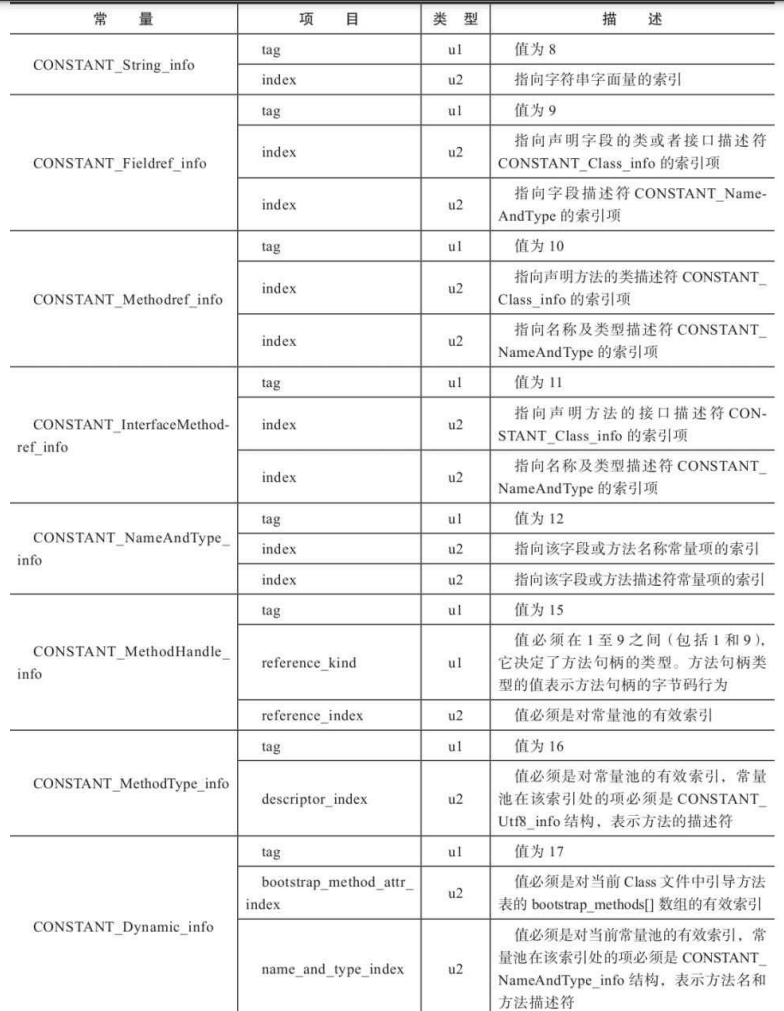

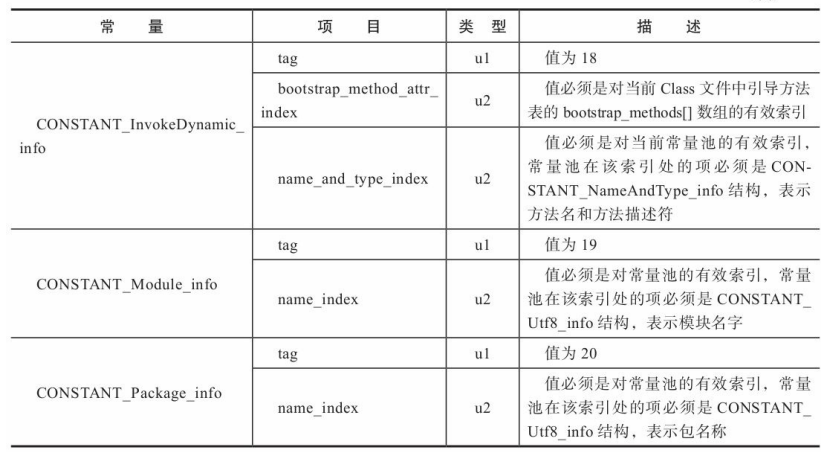

果然是有的233，javap 可以解析 class file。

### iii. 字段表类型和结构

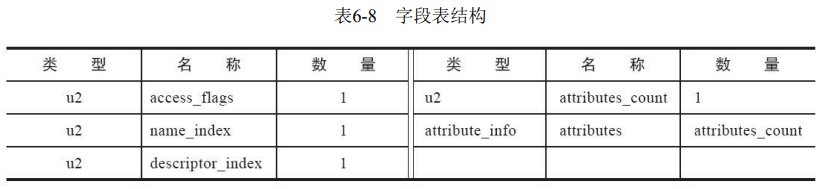

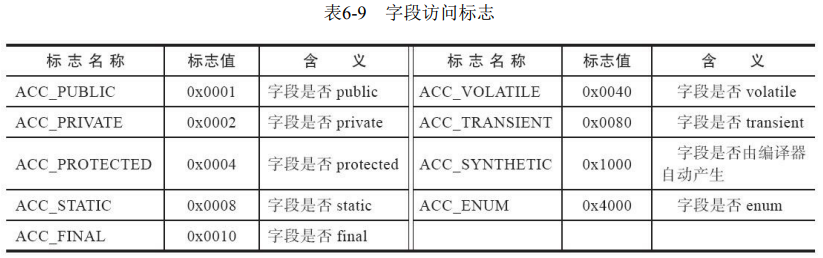

### iv. 描述字段

描述符标识（常量池出现，并且被同在常量池中的 “字段” 用于描述类型，如变量类型、方法形参类型、方法返回类型等）：

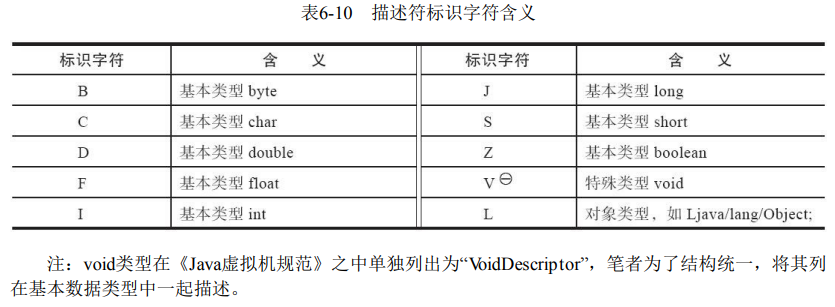

常见的 “Ljava/lang/Object” 中的 “L” 表示 “对象类型”。方法就是用括号括起形参；数组就是在类型前加一个 `[`。举个例子：

```java
public static void main(String args[]) {}
```

这个方法的描述符是：`([Ljava/lang/Object)V`。

### v. 方法表结构

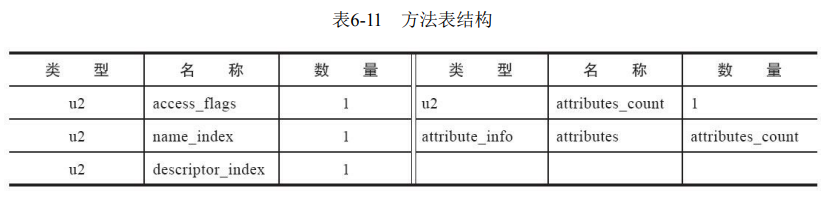

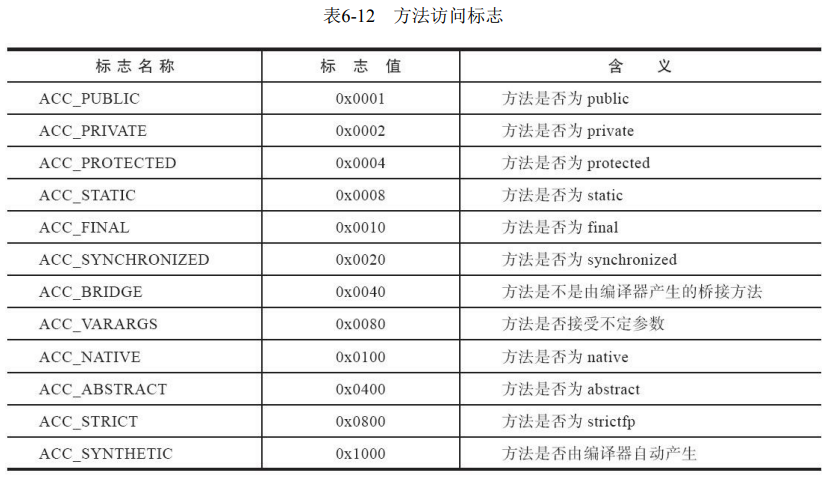

重载方法需要拥有一个和原方法不同的特征签名：**各个参数在常量池中的字段符号引用的集合**。

### vi. 属性表集合

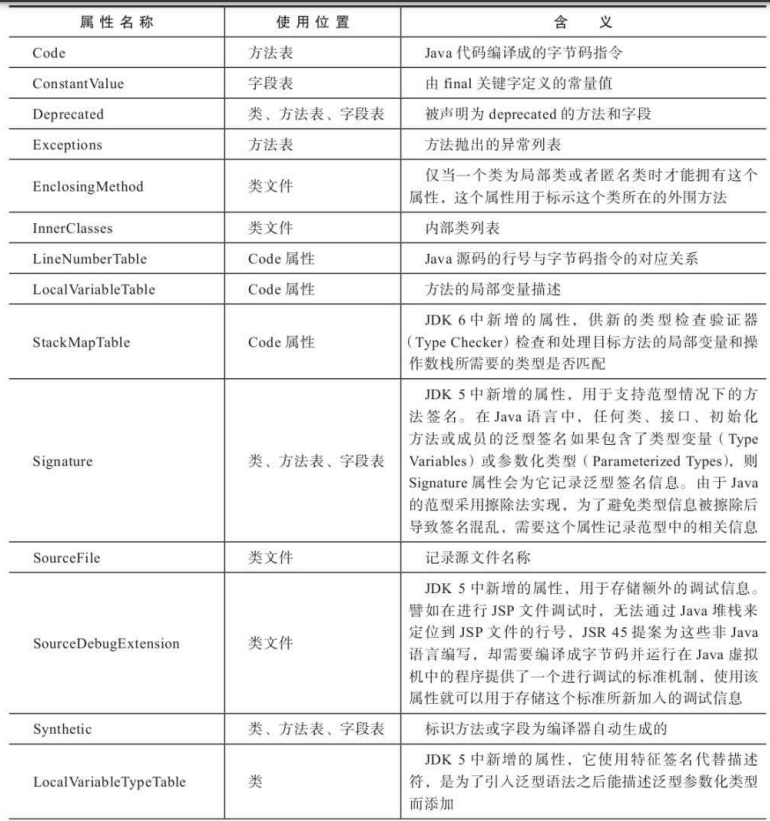

## 2. 类加载

Java 代码在被 javac 编译时，并不像 C / C++ 一样连接，而是在 JVM 加载 class file 时做动态连接。（也就是运行时）只有 class file 是不能直接运行程序或运行一部分程序的，需要 JVM 做内存空间分配。

Java 中类型的加载、连接、初始化过程都是在 **程序运行期间** 完成的。

> “一个面向接口应用程序可以在运行时再指定实际的实现类，用户可以通过 Java 预置或自定义 class loader，让某个本地应用在运行时从网络加载一个二进制流作为代码一部分。”
>
> “本章的 ‘Class 文件’ 并非特指存在于磁盘中的文件，而是一串二进制字节流。包括但不限于磁盘文件、网络、数据库、内存、动态生成。”

我惊了。

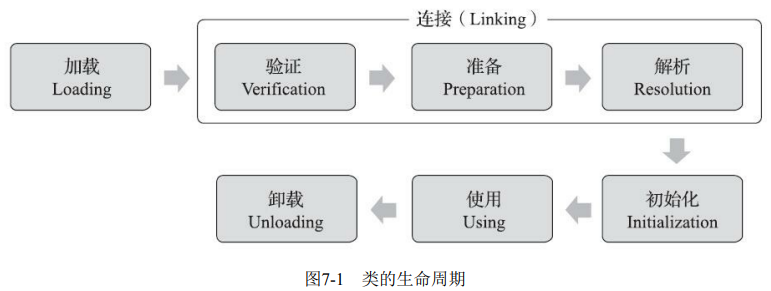

### i. 加载

**无论是加载，还是初始化，都是类加载过程的一个 Phase**。 算是扣个字眼，初始化在类加载概念之下。

加载阶段中，获得二进制字节流的方法并未限定。所以可以自定义类加载器。

JVM 将二进制字节流转换为 JVM 设定的格式存储在方法区中。此后 Java 堆内存中会实例化一个 java.lang.Class 类的对象，该对象是程序访问方法区中类型数据的外部接口。

（有一说一感觉书里的语句非常通俗以及现代化。并且在简练和准确这两个维度把握得很好）

### ii. 连接

#### a. 验证

说句不恰当的比喻，有点后端鉴权的感觉。因为 class file 格式紧凑且 public，所以 JVM 拿到手的 class file 并不一定是正常 javac 编译出来的。javac 自然要进行一些语法错误的处理，但如若 JVM 不检查输入的 bitstream，那同样可能出大错。

#### b. 准备

对类变量分配内存。Java 中的类变量指的是 static variables。但常量 final variables 是会在准备阶段赋值的，因为本身就是常量了。

```java
public static int value = 123;
public final int fvalue = 456;
public final static int fsvalue = 789;
```

在准备过程后，value 的值是初始化的 “零值”，而非 123。因为 “value = 123” 会在类初始化 \<cinit\>() 中执行。

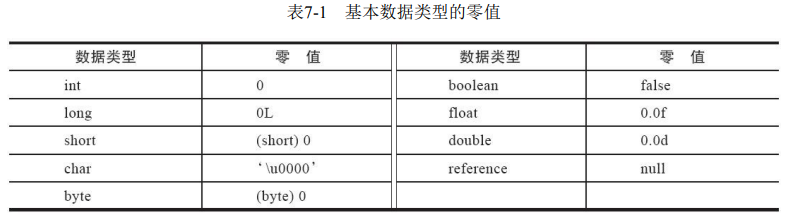

#### c. 解析

将常量池中的符号引用，替换为直接引用的过程。

常量池里面相同的事物只会出现一次，那么第二次出现就会使用符号引用——每个符号都有一个编号，第二次使用就一个 `#x` 指过去。

举个例子：

```classfile
 #1 = Methodref    #3.#14
 #3 = Class        #16
 #4 = Utf8         <init>
 #5 = Utf8         ()V
#14 = NameAndType  #4:#5
#16 = Utf8         demo/A
```

所以 `#1` 这个 Methodref 实际想表示：`demo/A.<init>:()V` 这个 demo/A 类的默认构造函数。话虽如此，但这个常量都是没有分配内存的。

上面的常量池是：

```java
package demo;

public class B extends A {
    public static void main(String[] args) {
        int b = 3;
    }

    public int add(String args[]) {
        return 50;
    }
}
```

这段代码的。对于这个 demo/B 类的初始化，可以看到：

```bytecode
public demo.B();
descriptor: ()V
flags: (0x0001) ACC_PUBLIC
Code:
  stack=1, locals=1, args_size=1
     0: aload_0
     1: invokespecial #1                  // Method demo/A."<init>":()V
     4: return
  LineNumberTable:
    line 3: 0
```

里面 invokespecial 的 `#1` 几经辗转就解析出了后面的 demo/A."\<init\>":()V。虽然说常量池中并没有直接显示定义，但是可以通过符号间的引用关系获得。

如果我的阅读理解没错的话，`#1` 是一个符号引用。
    
但很抱歉我对 Java 运行时内存结构一无所知，所以也不知道直接引用是什么形态了。

##### alpha. 类 / 接口符号引用解析

算是一个 “高阶” 行为。在未解析符号的解析时，如果这个符号的构成部分存在未解析的符号，那么就需要，将 **存在于某类代码** 中的该全限定名，传给该类的类加载器，然后再重走 “类解析” 过程，从加载开始。

##### beta. 字段符号引用解析

自底向上查找。先看该字段所在类是否存在该字段的定义；再接口递归查找；最后父类递归查找……

我觉得需要注意的 Java 特性：

1. Java 中接口定义的变量是 public static final 的；
2. Java 允许接口多继承。

##### gama. 实例方法解析

先看当前类中；再父类递归查找。

因为 JVM 中，接口方法和实例方法在常量池中的定义是不同的（CONSTANT_InterfaceMethodref_info 和 CONSTANT_Methodref_info），而且接口方法和对象实例方法是两种调用指令（invokeinterface 和 invokespecial），所以要分开。

**既然是 invokespecial 指令后跟着的符号，就不应该再在 interface implemented 中找到匹配方法**。

##### delta. 接口方法解析

就是对接口递归查找。

### iii. 初始化

加载动作肯定在初始化之前，但《JVM 规范》中没有硬性约束加载的条件，可是却硬性规定了初始化的 6 个条件。

1. new 实例化某类，get 或 put 一个未被 final 修饰的 static 变量，invokestatic；
2. java.lang.reflect 反射解析某类；
3. 初始化子类前，初始化父类；
4. 初始化定义好的带 main 方法的入口类；
5. （yysy，没见识过所以不懂）当使用JDK 7新加入的动态语言支持时，如果一个java.lang.invoke.MethodHandle实例最后的解析结果为REF_getStatic、REF_putStatic、REF_invokeStatic、REF_newInvokeSpecial四种类型的方法句柄，并且这个方法句柄对应的类没有进行过初始化，则需要先触发其初始化；
6. 定义了 default 方法的接口的实现类初始化前，初始化接口。

特殊的不会初始化类的情况：

1. 只是使用类型，而不填充对象，属于被动引用。比如定义一个对象数组，但数组没有初始化，数组类不通过类加载器创建；
2. 使用类中的 final static 变量；
3. 使用父类中的 static 变量，初始化父类，但不会初始化子类。

**初始化类就是执行 \<cinit\>() 的过程**，是类中定义的 static block 和对 static variable 赋值的语句集合。

## 3. 类加载器

一个类由加载它的 classloader 和其本身共同确立在 JVM 中的唯一性。

在比较两个类（Class.equals）时，只有 classloader 和其本身都相同，才是同一个类。

### i. JDK 8 前类加载器

看 WALA 中对 classloader 就有三种 ClassLoaderReference，分别是 Primordial(原初的) / Extension / Application。然后这个 Primordial 就是 JDK 8 前的 Bootstrap Classloader，用于加载例如 rt.jar 这样的类库。

```java
public class ClassLoaderReference implements Serializable {
    public static final ClassLoaderReference Primordial =
          new ClassLoaderReference(Atom.findOrCreateUnicodeAtom("Primordial"), Java, null);
    public static final ClassLoaderReference Extension =
          new ClassLoaderReference(Atom.findOrCreateUnicodeAtom("Extension"), Java, Primordial);
    public static final ClassLoaderReference Application =
          new ClassLoaderReference(Atom.findOrCreateUnicodeAtom("Application"), Java, Extension);

    public ClassLoaderReference(Atom name, Atom language, ClassLoaderReference parent) { /* some code */ }
}
```

然后继承关系如下：

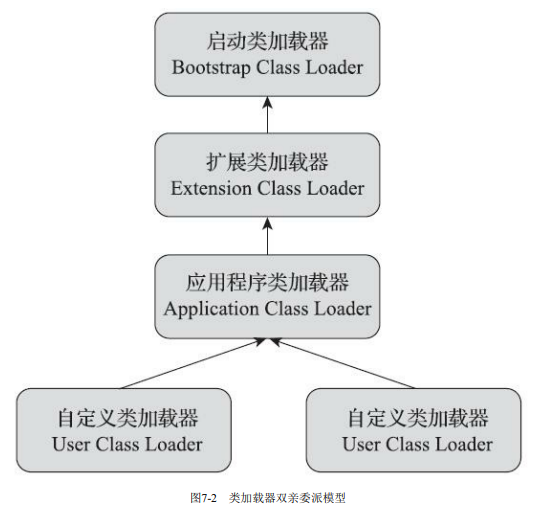

### ii. 双亲委派机制

属于是听说过很多遍但都没记住含义的古老名词了：

> 如果类收到加载请求，首先委派给父类完成，父类无法完成再由子类完成。

所以双亲委派机制的这个 **委派** 就是希望人在写代码的时候，先去调父类，而不是 **直接覆盖**。

## 3. 模块系统的类加载过程

由于分析的代码基本没有使用这方面功能，所以就不打算看了。